# Public Transport & Medical Care
### Import required libraries

In [ ]:
import requests
import pandas as pd
import numpy as np 
import random 
import math
import utm
from geopy.geocoders import Nominatim 
from pyproj import Proj
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 
from IPython.core.display import HTML 
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import folium 
import sklearn
from sklearn import neighbors
import seaborn as sns

#### Define function
##### 1. Get data for each category from Foursquare
##### 2. Apply haversine formular
##### 3. Filter and unpivot data frame

In [43]:
def Citydata(city):
    
    
    address = city
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

    # Getting all Doctors's Offices in desired City
    categoryId = '4bf58dd8d48988d177941735'
    radius = 5000

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, categoryId, radius, LIMIT)

    results = requests.get(url).json()
    venues = results['response']['venues']

    dataframe = json_normalize(venues)

    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    df1 = dataframe_filtered[["name", "lat", "lng", "distance"]]
    df1.loc[:, 'category'] = "Doctor"

    # Getting all Bus Stations in desired City

    categoryId = '4bf58dd8d48988d1fe931735'
    radius = 5000

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, categoryId, radius, LIMIT)

    results = requests.get(url).json()
    venues = results['response']['venues']

    dataframe = json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    df2 = dataframe_filtered[["name", "lat", "lng", "distance"]]
    df2.loc[:, 'category'] = 'Bus Station'

    # Converting lat & lon to radians

    df1[['lat_radians_A','long_radians_A']] = (
    np.radians(df1.loc[:,['lat','lng']]))

    df2[['lat_radians_B','long_radians_B']] = (
    np.radians(df2.loc[:,['lat','lng']]))

    df1 = df1.rename(columns={'name': "Doctor"})
    df2 = df2.rename(columns={'name': "Bus Station"})


    # Calculate distance using haversine formular in sklearn
    # 6371 -> earth radius in km & will return distance between locationss in km
    dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
    dist_matrix = (dist.pairwise
    (df1[['lat_radians_A','long_radians_A']],
     df2[['lat_radians_B','long_radians_B']])*6371)

    df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=df1['Doctor'], 
                 columns=df2['Bus Station']))



    df_dist_long = (pd.melt(df_dist_matrix.reset_index(),id_vars='Doctor'))
    df_dist_long = df_dist_long.rename(columns={'value':'km'})

    df_dist_long ["city"] = city
    city = df_dist_long.sort_values(by='km').drop_duplicates(['Doctor'], keep='first')
    city = pd.DataFrame(city)

    return city

### Run function for various cities
### Merge resulting dataframes

In [69]:
Dresden = Citydata("Dresden")
Leipzig = Citydata("Leipzig")
Chemnitz = Citydata("Chemnitz")
Rostock = Citydata("Rostock")
Potsdam = Citydata("Potsdam")

Osnabrück = Citydata("Osnabrueck")
Oldenburg = Citydata("Oldenburg")
Duisburg = Citydata("Duisburg")
Kiel = Citydata("Kiel")
Hannover = Citydata("Hannover")

### Create dataframes for each part in Germany
East = pd.concat([Dresden, Leipzig, Chemnitz, Rostock, Potsdam], ignore_index=True, sort=False)
West = pd.concat([Oldenburg, Osnabrück, Duisburg, Kiel, Hannover], ignore_index=True, sort=False)

### Merge dataframes to compare East and West Germany
East["Part"] = "East"
West["Part"] = "West"
DE = pd.concat([East, West], ignore_index=True, sort=False)
DE.head()

51.0493286 13.7381437


C:\Users\Jan\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Jan\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\Jan\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



51.3406321 12.3747329
50.8322608 12.9252977
54.0924445 12.1286127
52.4009309 13.0591397
52.266837 8.049741
53.1389753 8.2146017
51.434999 6.759562
54.3227085 10.135555
52.3744779 9.7385532


,Doctor,Bus Station,km,city,Part
0,Arztpraxis Dr. Bettina Rädel,Linie 61,0.054250,Dresden,East
1,Praxis Dr. K.Reißmann,H Wilder Mann,0.140030,Dresden,East
2,Ärztehaus,Koblenzerstraße,0.200504,Dresden,East
3,Gemeinschaftspraxis Für Nuklearmedizin - Fuchs...,Linie 94,0.330595,Dresden,East
4,"Dr. Ballmann, Dr. Goecke",Linie 61,0.340815,Dresden,East


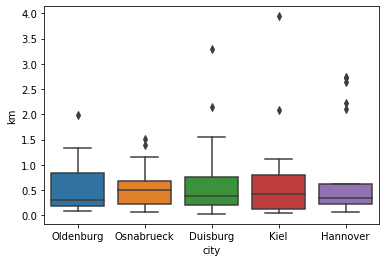

In [83]:
blubb = sns.boxplot(x="city", y="km", data=West)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.figure.savefig("East.png", dpi = 800)


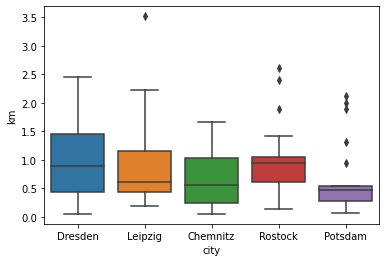

In [71]:
blubb = sns.boxplot(x="city", y="km", data=West)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.figure.savefig("East.png", dpi = 800)


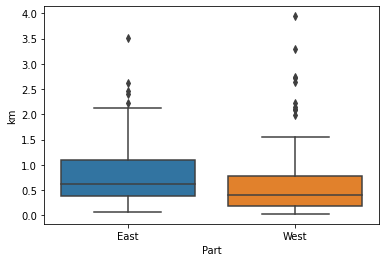

In [73]:
blubb = sns.boxplot(x="city", y="km", data=West)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.figure.savefig("East.png", dpi = 800)
